Data set from: https://archive.ics.uci.edu/ml/datasets/thyroid+disease

In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, datasets
import plotly.express as px
import plotly.subplots as sp
import matplotlib.patches as mpatches
import plotly.graph_objs as go

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer, precision_score, recall_score, roc_auc_score, roc_curve, auc, precision_recall_curve, mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.neighbors import KNeighborsClassifier

import missingno as msno

plt.rcParams['figure.figsize'] = 10, 10
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import io

from google.colab import files

In [ ]:
uploaded = files.upload()

Saving dataset_57_hypothyroid.csv to dataset_57_hypothyroid (4).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['dataset_57_hypothyroid.csv']), header=0)

In [ ]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

Everything is an object! There needs to be some work done here.
Let's take a peek at our target variable

In [ ]:
fig = px.histogram(df, x="Class", nbins = 50)
fig.show()

Our target variable is dominated by one result (negative) with much smaller portion of result in other categories. We're especially interested in any other classes than negative as all of them basically mean that the patient is diagnosed with some sort of thyroid disease. For ease of classification I'm going to combine them a bit further in a single cathegory. Precise diagnosis would have to be conducted by a doctor anyway, in this case we'd rather have a model that would help doctor with overall prediction.

Everything is an object now but after peeking into the database pretty much all columns should actually be classified as numerical or booleans.

Before we transform them lets look into missing data if there are any obvious candidates for dropping

Looks like no null values, lets double check

In [ ]:
df.isnull().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH_measured                 0
TSH                          0
T3_measured                  0
T3                           0
TT4_measured                 0
TT4                          0
T4U_measured                 0
T4U                          0
FTI_measured                 0
FTI                          0
TBG_measured                 0
TBG                          0
referral_source              0
Class                        0
dtype: int64

Looking at the head it seems that '?' was used as a marker for an unknown value let's check that instead

In [ ]:
df.eq('?').sum()

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
Class         

In [ ]:
df.eq('f').sum()

age                             0
sex                             0
on_thyroxine                 3308
query_on_thyroxine           3722
on_antithyroid_medication    3729
sick                         3625
pregnant                     3719
thyroid_surgery              3719
I131_treatment               3713
query_hypothyroid            3538
query_hyperthyroid           3535
lithium                      3754
goitre                       3738
tumor                        3676
hypopituitary                3771
psych                        3588
TSH_measured                  369
TSH                             0
T3_measured                   769
T3                              0
TT4_measured                  231
TT4                             0
T4U_measured                  387
T4U                             0
FTI_measured                  385
FTI                             0
TBG_measured                 3772
TBG                             0
referral_source                 0
Class         

Entire TBG column is missing. Also,

Out of 3772 data entries columns TBG_measured is filled with the same value meaning 'false' which corresponds to missing TBG values. These will be dropped as they do not introduce anything to the model.

There are a lot of columns columns which are very close to being uniform such as hypopituitary with only 1 value NOT being false. However since this is a medical data set we're working with I will not drop any of these as they might be meaningful in predicting diagnosis.

In [ ]:
df.drop(columns = ['TBG_measured', 'TBG'], inplace = True)

We can see above that the number of '?' values above in columns related to measurements corresponds directly with amount of 'f' values in the xxx_measured columns. We can drop all the xxx_measured columns as the corresponding xxx columns already contain the same information

In [ ]:
df.drop(columns = ['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured'], inplace = True)

Let's wrangle data types

In [ ]:
for i in range(2, 16):
    df.iloc[:,i] = df.iloc[:,i].map({'t':True, 'f':False})

In [ ]:
# sanity check
df.eq('f').sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH                          0
T3                           0
TT4                          0
T4U                          0
FTI                          0
referral_source              0
Class                        0
dtype: int64

In [ ]:
df.replace(to_replace="?",value=np.nan,inplace=True)

In [ ]:
for i in ['age' , 'TSH' , 'T3' , 'TT4' , 'T4U', 'FTI']:
    df[i] = df[i].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   bool   
 3   query_on_thyroxine         3772 non-null   bool   
 4   on_antithyroid_medication  3772 non-null   bool   
 5   sick                       3772 non-null   bool   
 6   pregnant                   3772 non-null   bool   
 7   thyroid_surgery            3772 non-null   bool   
 8   I131_treatment             3772 non-null   bool   
 9   query_hypothyroid          3772 non-null   bool   
 10  query_hyperthyroid         3772 non-null   bool   
 11  lithium                    3772 non-null   bool   
 12  goitre                     3772 non-null   bool   
 13  tumor                      3772 non-null   bool 

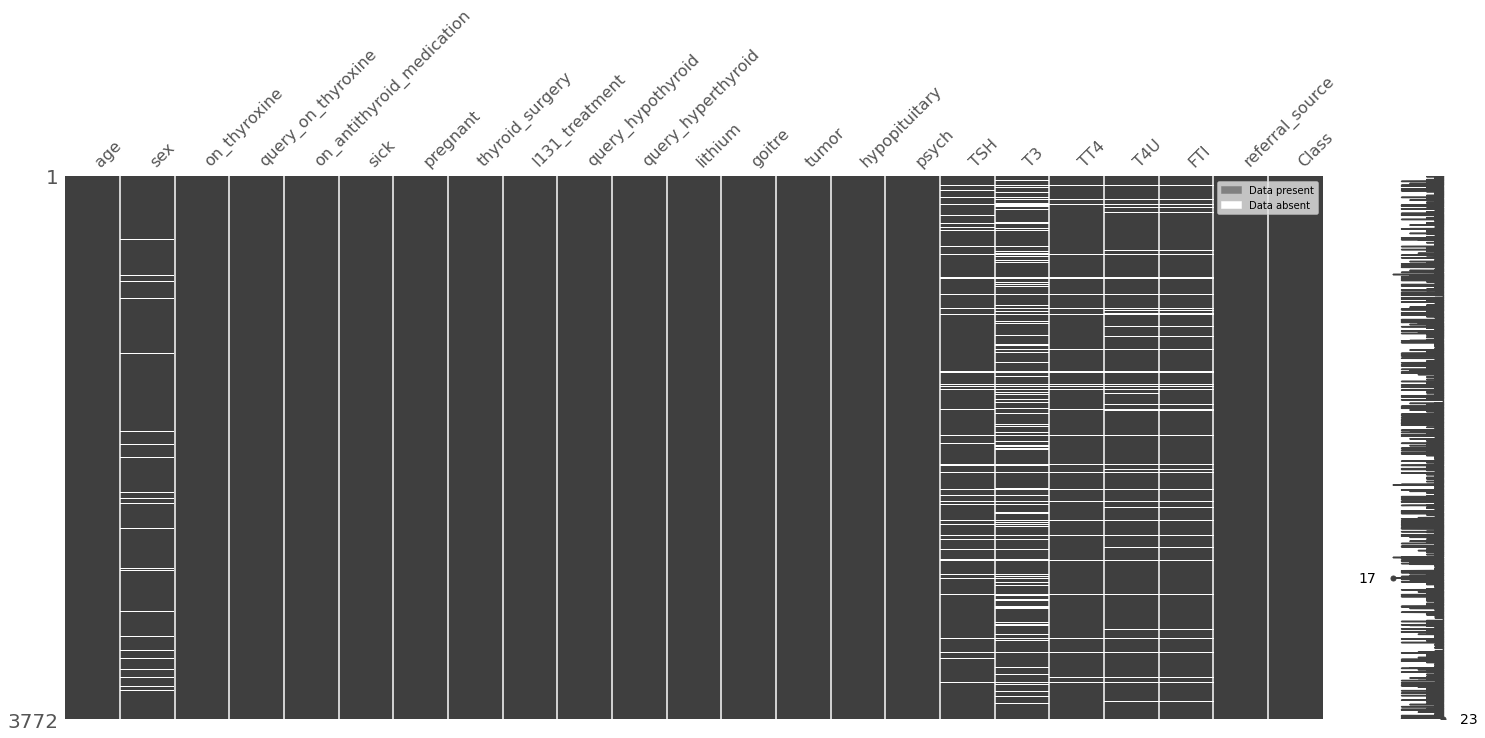

In [ ]:
msno.matrix(df)
gray_patch = mpatches.Patch(color='gray', label='Data present')
white_patch = mpatches.Patch(color='white', label='Data absent')
plt.legend(handles=[gray_patch, white_patch])

plt.show()

In [ ]:
df.isnull().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

For some patients testing was not conducted (TSH to FTI columns). This seems to be random enough but usually if patient was tested for one, he was more likely tested for others too. Since this does not represent a large chunk of the data and imputing medical records seems like introducing a significant bias into the model I'm going to drop rows with empty values. The dataset will be smaller but for sake of finding variables that can help predict disease i think we can live with a smaller set that includes more diagnostic tests done.

Note  - if more time was available it might be useful to make another model with imputation for at least sake of T3 variable which costs us quite a lot of rows. Then we could compare if they were actually significant or not.

In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2643 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        2643 non-null   float64
 1   sex                        2643 non-null   object 
 2   on_thyroxine               2643 non-null   bool   
 3   query_on_thyroxine         2643 non-null   bool   
 4   on_antithyroid_medication  2643 non-null   bool   
 5   sick                       2643 non-null   bool   
 6   pregnant                   2643 non-null   bool   
 7   thyroid_surgery            2643 non-null   bool   
 8   I131_treatment             2643 non-null   bool   
 9   query_hypothyroid          2643 non-null   bool   
 10  query_hyperthyroid         2643 non-null   bool   
 11  lithium                    2643 non-null   bool   
 12  goitre                     2643 non-null   bool   
 13  tumor                      2643 non-null   bool 

In [ ]:
df.Class.unique()

array(['negative', 'primary_hypothyroid', 'compensated_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [ ]:
df['referral_source'] = df['referral_source'].map({'SVHC': 1, 'SVI': 2, 'other': 3, 'SVHD': 4, 'STMW': 5})

In [ ]:
df['is_female'] = df['sex'].map({'F': True, 'M': False})

In [ ]:
df.drop(columns = ['sex'], inplace=True)

In [ ]:
df['Class'] = df['Class'].map({'negative': False, 'primary_hypothyroid': True, 'compensated_hypothyroid': True, 'secondary_hypothyroid': True})

In [ ]:
df['referral_source'] = df['referral_source'].astype(float)

In [ ]:
df.referral_source.unique()

array([1., 2., 3., 4., 5.])

In [ ]:
df.shape

(2643, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2643 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        2643 non-null   float64
 1   on_thyroxine               2643 non-null   bool   
 2   query_on_thyroxine         2643 non-null   bool   
 3   on_antithyroid_medication  2643 non-null   bool   
 4   sick                       2643 non-null   bool   
 5   pregnant                   2643 non-null   bool   
 6   thyroid_surgery            2643 non-null   bool   
 7   I131_treatment             2643 non-null   bool   
 8   query_hypothyroid          2643 non-null   bool   
 9   query_hyperthyroid         2643 non-null   bool   
 10  lithium                    2643 non-null   bool   
 11  goitre                     2643 non-null   bool   
 12  tumor                      2643 non-null   bool   
 13  hypopituitary              2643 non-null   bool 

I have spent way too many hours today trying to get the pipeline to work with encoding categorical variables using OneHotEncoder down below in the notebook. Eventually I got frustrated and decided the same information can be conveyed using booleans or numerical values... Let's focus on finding diagnosis of any thyroid disease without differentiating at this stage

# Data Normalization and Encoding, Logistic regression model

Standard scaler for numerical values, one hot encoder for categorical, and label encoder for boolean and target variables. 

In [ ]:
#original
num_cols = ['age','TSH','T3','TT4','T4U','FTI','referral_source']
bool_cols = ['is_female', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych']
target_col = 'Class'
target = df[target_col].values

num_pipe = Pipeline([
    ('scaler', StandardScaler()),
  
])



pipe = ColumnTransformer(transformers=[

    ('num', num_pipe, num_cols),

])




In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(target_col, axis=1), target, test_size=0.2, random_state=2137, shuffle=True)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2114, 22), (529, 22), (2114,), (529,))

In [ ]:
x = pipe.fit_transform(x_train)

In [ ]:
x_train_tr = pipe.fit_transform(x_train)
x_test_tr = pipe.transform(x_test)

As seen in previous steps the target variable is imbalanced with majority falling into 'negative' category. Accuracy should not be our main focus here as it may lead to a model that does everything well except diagnosing patients. For this reason I'll investigate precision, recall and ROC metrics.

In [ ]:
model = LogisticRegression(C=0.1, max_iter = 20000)
model.fit(x_train_tr, y_train)

LogisticRegression(C=0.1, max_iter=20000)

In [ ]:
scores = cross_val_score(model, x_train_tr, y_train, cv=5)
scores

array([0.94326241, 0.94089835, 0.94562648, 0.93617021, 0.95734597])

In [ ]:
predictions = model.predict(x_test_tr)

predictions_prob = model.predict_proba(x_test_tr)

In [ ]:
cm = confusion_matrix(y_test, predictions)

In [ ]:
cr = classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

       False       0.95      1.00      0.97       488
        True       0.94      0.41      0.58        41

    accuracy                           0.95       529
   macro avg       0.95      0.71      0.78       529
weighted avg       0.95      0.95      0.94       529



The model is highly accurate and precise. It does however do a poor job in predicting actual positive cases as postiive ( low recall). In my view this is the single most important metric while predicting diseases, lets investigate further.

In [ ]:
trace = go.Heatmap(z=cm, x=['Predicted Healthy', 'Predicted Disease'], y=['Actual Healthy', 'Actual Disease'], colorscale='Viridis')

layout = go.Layout(title='Confusion Matrix', xaxis=dict(title='Predicted'), yaxis=dict(title='Actual'))
fig = go.Figure(data=[trace], layout=layout)

fig.show()

In [ ]:
y_scores = predictions_prob[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

trace1 = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc)
trace2 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='No Skill', line=dict(color='black', dash='dash'))
layout = go.Layout(title='ROC Curve', xaxis=dict(title='False Positive Rate'), yaxis=dict(title='True Positive Rate'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

trace = go.Scatter(x=recall, y=precision, mode='lines', name='Precision-Recall Curve')
layout = go.Layout(title='Precision-Recall Curve', xaxis=dict(title='Recall'), yaxis=dict(title='Precision'))
fig = go.Figure(data=[trace], layout=layout)
fig.show()

Both curves suggest to us that the model is decent but has some room for improvement. We can clearly see that the precision for the model is generally quite high but we struggle to gain recall which is probably one of the most important indicator when it comes to medical tests. Recall below 50% means that if you are actually sick you have less than 50% chance of being diagnosed. We can do better. The area under the curve is significant 0.95 but lets aim for more. In auc-roc curve we aim to be as close to the left corner as possible.

# Regularization

In [ ]:
log_ridge = LogisticRegression(penalty='l2', C=0.6)

In [ ]:
log_ridge.fit(x_train_tr, y_train)

LogisticRegression(C=0.6)

In [ ]:
predictions = log_ridge.predict(x_test_tr)


predictions_prob = log_ridge.predict_proba(x_test_tr)


In [ ]:
scores = cross_val_score(log_ridge, x_train_tr, y_train, cv=5)
scores

array([0.94562648, 0.94562648, 0.95981087, 0.94326241, 0.9549763 ])

In [ ]:
cr = classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

       False       0.96      1.00      0.98       488
        True       0.90      0.46      0.61        41

    accuracy                           0.95       529
   macro avg       0.93      0.73      0.79       529
weighted avg       0.95      0.95      0.95       529



I have tried multiple different values of C parameter but could not bring recall any higher than this. Ridge regularisation seems to have improved the logistic regression by a small margin

In [ ]:
cm = confusion_matrix(y_test, predictions)

In [ ]:
trace = go.Heatmap(z=cm, x=['Predicted Healthy', 'Predicted Disease'], y=['Actual Healthy', 'Actual Disease'], colorscale='Viridis')

layout = go.Layout(title='Confusion Matrix - after Ridge regularization', xaxis=dict(title='Predicted'), yaxis=dict(title='Actual'))
fig = go.Figure(data=[trace], layout=layout)

fig.show()

In [ ]:
y_scores = predictions_prob[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

trace1 = go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc)
trace2 = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='No Skill', line=dict(color='black', dash='dash'))
layout = go.Layout(title='ROC Curve', xaxis=dict(title='False Positive Rate'), yaxis=dict(title='True Positive Rate'))
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

trace = go.Scatter(x=recall, y=precision, mode='lines', name='Precision-Recall Curve')
layout = go.Layout(title='Precision-Recall Curve', xaxis=dict(title='Recall'), yaxis=dict(title='Precision'))
fig = go.Figure(data=[trace], layout=layout)
fig.show()

Again, here we see that the regularisation has improved the model. Area under the ROC curve has improved to 0.98 and we can select a point with overall better true positive and false positive ratios.

#KNN

finally let's try K-nearest neighbours

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train_tr, y_train)

KNeighborsClassifier()

In [ ]:
scores = cross_val_score(knn, x_train_tr, y_train, cv=5)
scores

array([0.95035461, 0.94089835, 0.95508274, 0.93144208, 0.95971564])

The cross validation scores for each models are roughly the same oscillating around 0.95. The non-regularized logarithmic regression was a tiny bit smaller but overall in all three cases we see indication of healthy models with good data split

In [ ]:
y_pred = knn.predict(x_test_tr)

In [ ]:
y_probs = knn.predict_proba(x_test_tr)

Let's test the optimal number of neighbours

In [ ]:
k_list = list(range(1, 15))


k_scores = []


for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_tr, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

Text(0.5, 0, 'k')

Text(0, 0.5, 'accuracy')

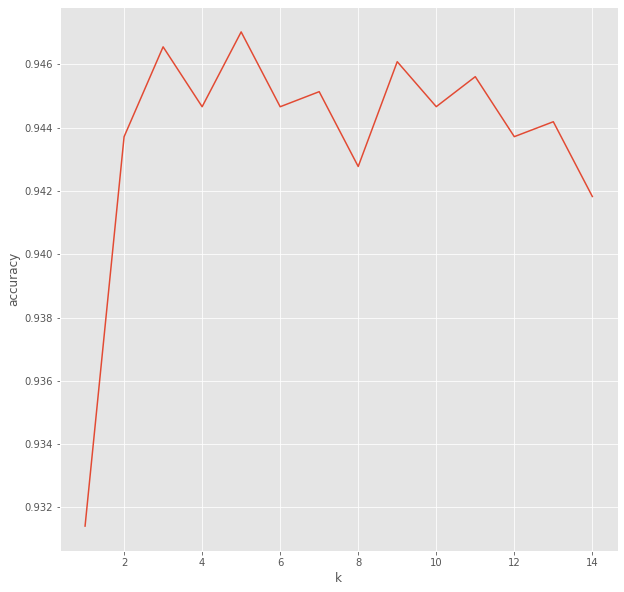

In [ ]:
import matplotlib.pyplot as plt

plt.plot(k_list, k_scores)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

accuracy is maximixed with k=5. The optimisation wasn't so easy to interpret using recall so i stayed with maximising accuracy on this one. This would not however be most important parameter in an imbalanced dataset with majority of negative cases where detection of a positive case is a priority. Recall would be better variable to optimize. I did try different k values manually though (you're welcome to try yourself) and k=5 performed best in relation to recall as well.

In [ ]:
predictions = knn.predict(x_test_tr)

cm = confusion_matrix(y_test, predictions)

trace = go.Heatmap(z=cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'], colorscale='Viridis')
layout = go.Layout(title='Confusion Matrix', xaxis=dict(title='Predicted'), yaxis=dict(title='Actual'))
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [ ]:
predictions = knn.predict(x_test_tr)

cr = classification_report(y_test, predictions)
print(cr)

              precision    recall  f1-score   support

       False       0.96      1.00      0.98       488
        True       0.95      0.49      0.65        41

    accuracy                           0.96       529
   macro avg       0.96      0.74      0.81       529
weighted avg       0.96      0.96      0.95       529



It seems that using KNN our model is performing exceptionally well on negative classes predicting the absence of the thyroid disease but the low True Recall score meaning that only 49% of the actual positive samples were correctly predicted as positive is concerning. In other words if you received a positive diagnosis using this predictor there is around 95% chance that you actually unhealthy (true precision) and if you received a negative diagnosis there is a 96% chance you are actually healthy (false precision). These 4% chance that you might be actually in bad shape is concerning and translates to very low True Recall score, meaning we're losing around half of actually positive cases.

I have tried a set of different values of k and it seems shat 0.49 recall is maximum of what we can achieve in this case with KNN. Though overall performance of the model is good, there might be a different model more suitable, or perhaps the imbalance of dataset wasn't properly taken into account. This is a better score than any logistic regression we've tried before though.

ROC curve and precision-recall curve are not directly applicable to KNN, since the KNN algorithm does not predict the class probabilities, so they won't be considered here this time.

It is probably a good idea to try different classification mechanisms such as random forest that i did not learn yet, hopefully we'll come back to exploring this in further weeks.